# به نام خدا







# <font color='blue'>  پیشبینی داده کیفیت هوا با استفاده از مدل های سری زمانی در پایتون  </font> 
 

####  تهیه کننده :حسام افشار

#### استاد درس : جناب آقای دکتر صالحی راد 

# مقدمه

### مسئله کیفیت هوا و دما یکی از مسائل مهم در زندگی امروزه است که میتوان با استفاده از مدل های سری زمانی و شبکه های عصبی روند آینده دما و کیفیت هوا را با استفاده از داده های گذشته پیشبینی کرد ودر صورت لزوم با اصلاح موارد لازم روند را به سمت مطلوب سوق داد.
### در این پروژه هدف پیش بینی مقدار آلاینده ها در آینده است. 
### داده های این مسئله از سایت UCI به دست آمده. در این سایت آرشیوی از داده های مناسب برای مسائل آموزشی در حوزه یادگیری ماشین و علم داده وجود دارد.
### در بخش اول این ارائه به پردازش و تهیه مدلی کلاسیک برای داده ها میپردازیم سپس در بخش بعدی به طراحی مدلی مبتنی بر شبکه عصبی LSTM برای داده های میپردازیم.
### بخش اول شامل :
  * خواندن دیتا و تمیز کردن دیتا از داده های از دست رفته  (Data Cleaning) 
  * خلاصه از  داده ها مانند میانگین انحراف معیار و.. / رسم نمودار آنها نسبت به زمان / و رسم نمودار ضرایب همبستگی متغییر ها با یک دیگر (Exploratory Data Analysis)
  * تست فرضیه های مورد نیاز (Hypothesis) 
  * و در آخر برازش مدل کلاسیک کناسب برای داده ها (Modeling)

### و بخش نهایی شامل آماده سازی دیتا برای برازش مدل LSTM و برازش بهترین مدل با کمترین خطا است.

# فراخوانی کتابخانه ها

### ایتدا همه کتابخانه هایی که در انجام این پروژه مورد نیاز است را فراخوانی میکنیم

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#For Classic models part
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR, VARMAX
from statsmodels.tsa.stattools import acf, q_stat, adfuller

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import datetime
from sklearn import preprocessing

from scipy.stats import probplot, moment
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
warnings.filterwarnings("ignore")

#For Lstm part
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
import plot_keras_history
from sklearn.model_selection import train_test_split
import os
from numpy.random import seed 
from plot_keras_history import plot_history

SEED = 42
# Fix seed for reproducible results
os.environ['PYTHONHASHSEED']=str(SEED)
seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# فراخوانی داده ها
### مجموعه داده شامل 9357 نمونه از پاسخ های میانگین ساعتی از آرایه ای از 5 حسگر شیمیایی اکسید فلزی است که در یک دستگاه چند حسگر شیمیایی با کیفیت هوا تعبیه شده اند. این دستگاه در زمین در یک منطقه به طور قابل توجهی آلوده، در سطح جاده، در یک شهر ایتالیا قرار داشت. داده ها از مارس 2004 تا فوریه 2005 (یک سال) ثبت شد که نشان دهنده طولانی ترین ضبط های آزادانه در دسترس از پاسخ های دستگاه های حسگر شیمیایی کیفیت هوای مستقر در میدان است.غلظت های میانگین ساعتی CO، هیدروکربن های غیر متانیک، بنزن، اکسیدهای نیتروژن کل (NOx) و دی اکسید نیتروژن (NO2) و توسط یک آنالایزر گواهی شده مرجع ارائه شده.
### داده ها به صورت یک فایل اکسل است که آنها را فراخوانی و در جدول زیر 5 سطر ابتدایی آنها قابل مشاهده است و همچنین شامل 15 ستون به شرح زیر است:
* 0 تاریخ (DD/MM/YYYY)
* 1 زمان (HH.MM.SS)
* 2 غلظت میانگین ساعتی واقعی CO بر حسب mg/m^3 (آنالیزور مرجع)
* 3 PT08.S1 (اکسید قلع) پاسخ سنسور میانگین ساعتی (به طور اسمی CO هدفمند)
* 4 میانگین ساعتی واقعی غلظت کلی هیدروکربن های غیر متانیک بر حسب میکروگرم بر مترمربع 3 (آنالیزور مرجع)
* 5 غلظت متوسط ساعتی واقعی بنزن در میکروگرم بر مترمربع 3 (آنالیزور مرجع)
* 6 PT08.S2 (تیتانیا) پاسخ سنسور میانگین ساعتی 
* 7 غلظت میانگین ساعتی NOx واقعی در ppb (آنالیزور مرجع)
* 8 PT08.S3 (اکسید تنگستن) پاسخ سنسور میانگین ساعتی 
* 9 غلظت میانگین ساعتی NO2 واقعی در میکروگرم بر مترمربع 3 (آنالیزور مرجع)
* 10 پاسخ سنسور میانگین ساعتی 10 PT08.S4 (اکسید تنگستن) 
* 11 پاسخ سنسور میانگین ساعتی 11 PT08.S5 (اکسید ایندیم) 
* 12 درجه حرارت در درجه سانتیگراد
* 13 رطوبت نسبی (%)
* 14 AH رطوبت مطلق


In [2]:
df=pd.read_excel('AirQualityUCI.xlsx')
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [3]:
df.shape

(9357, 15)

# Data cleaning
### در داده های واقعی معمولا با این مشکل رو به رو میشویم که داده های از دست درون مجموعه داده وجود دارد که در توضیحات داده ها درون سایت گفته شده بجای مقادیر از دست رفته -200 گذاشته شده به همین خاطر ابتدا بجای آنها مقدار خاری میگذاریم سپس مقادیر خالی را با استفاده از درون یابی برآورد میکنیم.
### در پایین تعداد داده های از دست رفته در هر ستون نمایش داده شده است.

In [4]:
df.replace({-200:None}, inplace=True)
df.isnull().sum()

Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

### با کد زیر مقادیر درون یابی شده و تعداد مقادیر از دست رفته بعد از درون یابی نمایش داده شده

In [5]:
hourly_data=df.interpolate(method='bfill',limit_direction='backward')
hourly_data.isnull().sum()

Date                0
Time                0
CO(GT)              0
PT08.S1(CO)         0
NMHC(GT)         8126
C6H6(GT)            0
PT08.S2(NMHC)       0
NOx(GT)             0
PT08.S3(NOx)        0
NO2(GT)             0
PT08.S4(NO2)        0
PT08.S5(O3)         0
T                   0
RH                  0
AH                  0
dtype: int64

### همانطور که میبینیم ستون NMHC(GT) شامل تعداد زیادی داده از دست رفته است پس جزو هدف مسئله نیست پس آنرا از داده ها حذف میکنیم.

In [6]:
hourly_data.drop(['NMHC(GT)'], axis= 1, inplace= True)

### گفته شد داده ها به صورت ساعتی جمع آوری شده ولی من در طول انجام پروژه با این مشکل روبرو میشدم که برازش مدل و بررسی فرضیه های ایستایی داده ها بر روی داه های ساعتی دچار اشکال بود به خاطر همین داده ها را به داده های روزانه تبدیل کرده و برای آنها مدل کلاسیک برازش میدهیم.

In [7]:
days=[]
month=[]
year=[]
for i in hourly_data['Date']:
    days.append(i.day)
    month.append(i.month)
    year.append(i.year)
hourly_data['Day']=days
hourly_data['month']=month
hourly_data['year']=year

daily_data=pd.DataFrame()
for col in hourly_data.columns[2:-3]:
    val=[]
    ymd=[]
    for y in [2004,2005]:
        for m in range(1,13):
             for d in range(1,32):
                x=hourly_data[col][hourly_data['Day']==d][hourly_data['month']==m][hourly_data['year']==y]
                if len(x)!=0:
                    ymd.append(datetime.datetime(y, m, d).date())
                    val.append(x.mean())
    daily_data['Date']=ymd        
    daily_data[col]=val
daily_data.head()

,Date,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,1.966667,1316.500000,8.460790,912.250000,132.000000,1167.250000,108.833333,1545.333333,1096.041667,12.020833,54.883334,0.765626
1,2004-03-11,2.175000,1244.062500,7.989058,851.802083,139.250000,1277.187500,97.125000,1522.697917,885.031250,9.833333,64.069791,0.775768
2,2004-03-12,2.725000,1281.562500,12.129509,1008.229167,167.916667,1101.718750,113.000000,1627.218750,1084.218750,11.292708,51.107292,0.663102
3,2004-03-13,2.625000,1330.555556,10.922887,992.822917,181.291667,993.159722,117.375000,1595.621528,1245.781250,12.866319,51.530903,0.732294
4,2004-03-14,2.416667,1360.927083,9.631442,943.854167,143.416667,1001.104167,109.208333,1602.187500,1234.177083,16.016667,48.843750,0.849674


# EDA
### در زیر خلاصه ای از داده ها به صورت جدول و نمودار داده ها نسبت به زمان رسم شده که میتوان دید بعضی از ویژگی ها  رفتاری مشابه نسبت به هم  دارند.

In [8]:
data=daily_data
data.describe()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000
mean,2.178406,1103.658143,10.162442,941.483824,242.905006,833.209118,109.848195,1453.383694,1034.536901,18.134855,49.567172,1.021084
std,0.923167,147.453458,4.308578,155.633327,155.880294,176.849500,32.544868,270.366717,290.528042,7.869871,12.916331,0.386441
min,0.129167,724.697917,1.431244,524.489583,32.000000,476.000000,29.000000,698.937500,379.958333,1.430208,24.322917,0.240008
25%,1.522917,995.234375,6.770539,828.489583,125.916667,707.013889,87.250000,1281.390625,823.885417,11.961979,39.191840,0.735903
50%,2.137500,1098.614583,10.101067,943.854167,198.041667,816.871528,107.208333,1505.281250,1017.739583,17.791320,49.104166,1.002805
75%,2.679167,1201.564236,13.177692,1057.008681,324.750000,939.190972,128.441667,1667.276042,1216.855903,24.631944,59.222395,1.299106
max,5.320833,1521.000000,25.472303,1412.020833,821.541667,1678.687500,217.700000,1959.208333,2141.000000,32.997917,81.104167,1.997819


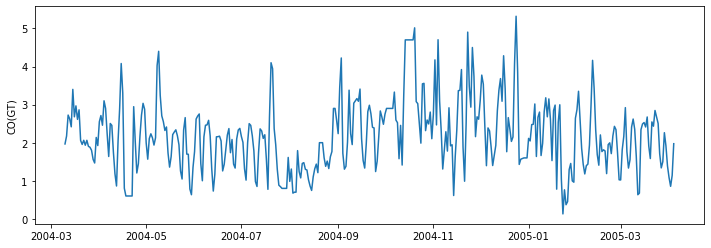

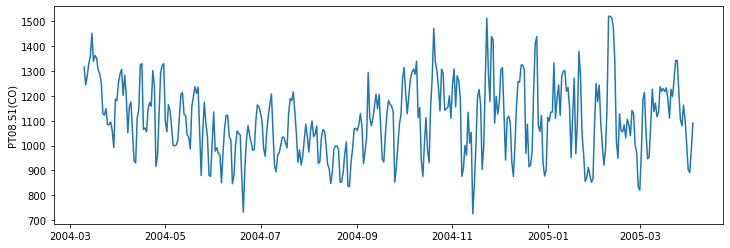

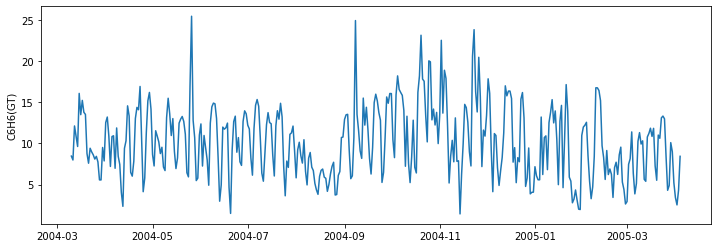

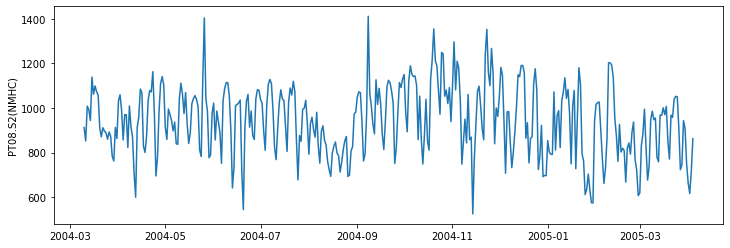

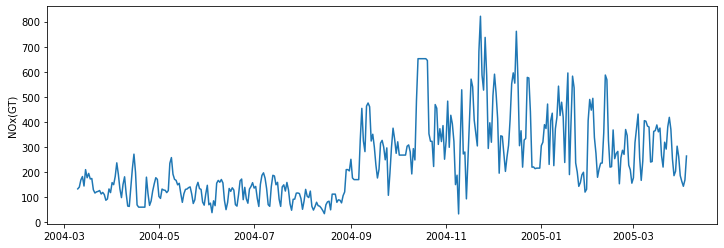

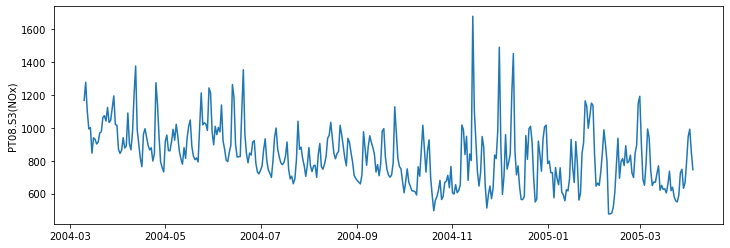

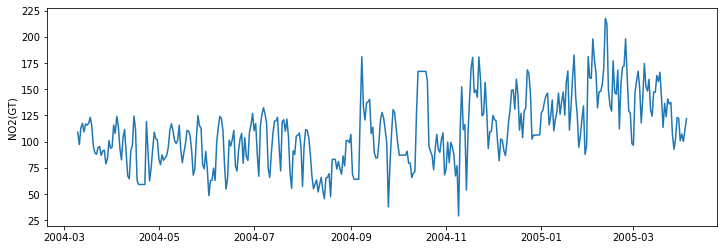

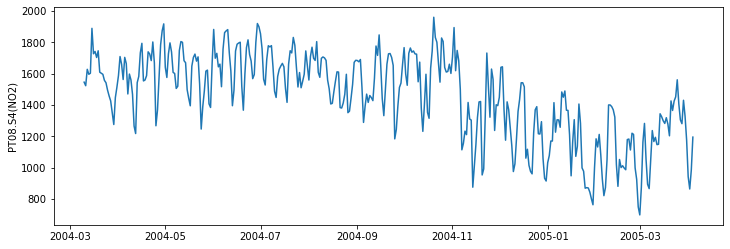

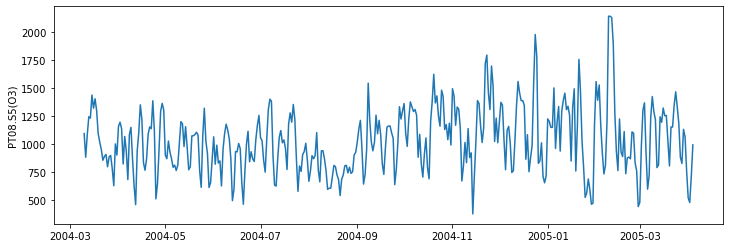

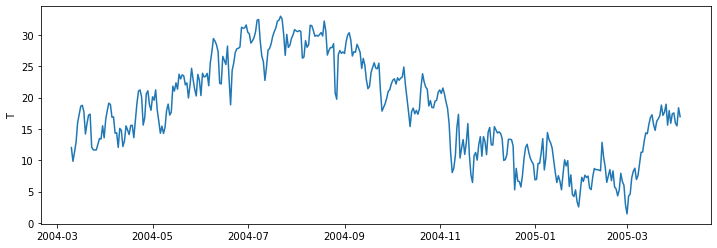

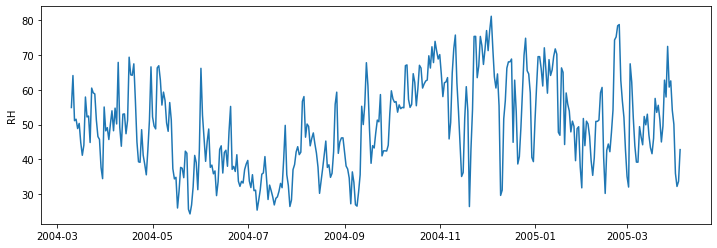

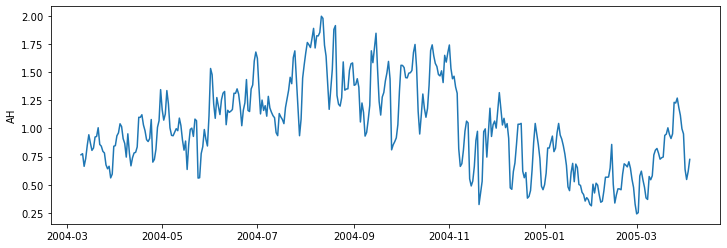

In [9]:
for col in data.columns[1:] :
    plt.subplots(figsize=(12,4))
    plt.plot(data['Date'],data[col])
    plt.ylabel(col) 
    plt.show()
    

### در بخش پایین نمودار میزان همبستگی تمام متغییر ها با هم نشان داده شده (درون هر خانه ضریب همبستگی بین متغییر های مربوط به آن خانه است)که به ما در پیدا کردن آلاینده هایی که بیشترین هبستگی را با هم دارند کمک میکند.  

<AxesSubplot:>

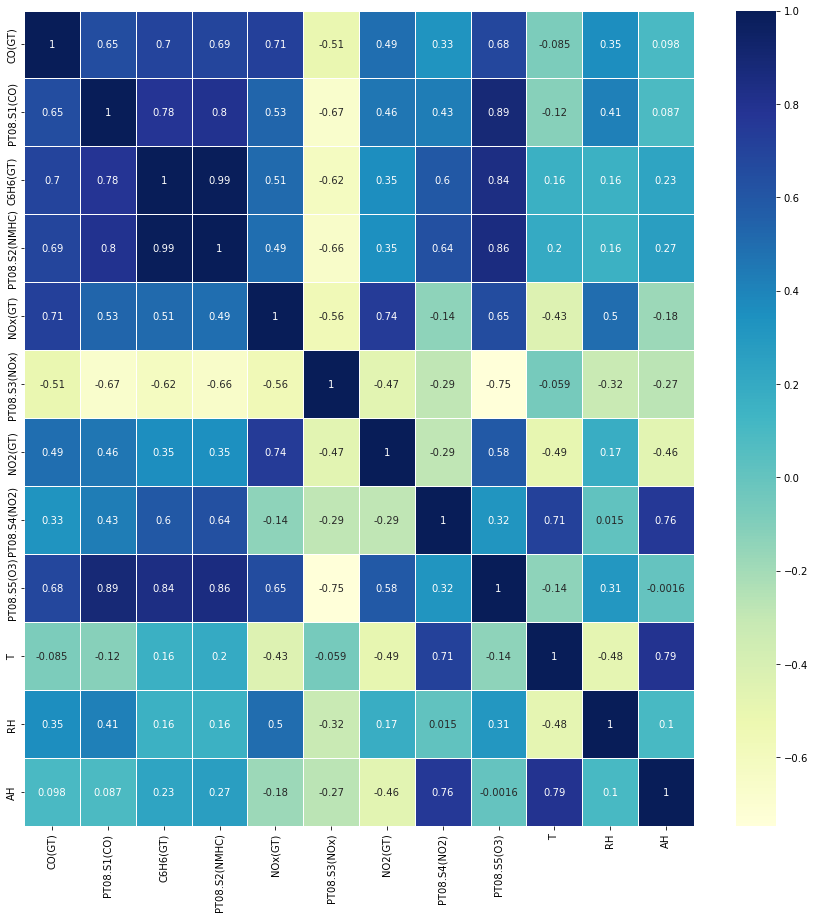

In [10]:
correlations = data.corr()
f,ax = plt.subplots(figsize=(15,15))
sns.heatmap(correlations, annot=True, cmap="YlGnBu", linewidths=.5)

### پس متغییر هایی که بیشترین همبستگی را باهم دارند (ضریب همبستگی بالای 0.5)  را از داده ها جدا میکنیم چون هدف ما پیشبینی آینده آلاینده ها است پس متغییر های روی همه آنها اثر دارند مهم است که با توجه به جدول بالا خود آلاینده ها هستند که بروی یکدیگر اثر گذارند.
### در پایین ابتدا جدول ضرایب همبستگی بعد از حذف متغییر های اضافی و بعد جدول داده ها بعد از حذف متغییر ها نشان داده شده است.

In [11]:
# Create correlation matrix
corr_matrix = data[list(data.columns[:7])].corr().abs()

# Find features with correlation greater than 0.5
to_drop = [column for column in corr_matrix.columns if all(corr_matrix[column]>= 0.49)]

data[to_drop].corr()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx)
CO(GT),1.000000,0.645873,0.696475,0.691049,0.714067,-0.511690
PT08.S1(CO),0.645873,1.000000,0.778525,0.795707,0.533657,-0.674147
C6H6(GT),0.696475,0.778525,1.000000,0.988913,0.513866,-0.616746
PT08.S2(NMHC),0.691049,0.795707,0.988913,1.000000,0.494665,-0.657301
NOx(GT),0.714067,0.533657,0.513866,0.494665,1.000000,-0.560222
PT08.S3(NOx),-0.511690,-0.674147,-0.616746,-0.657301,-0.560222,1.000000


In [12]:
data=data[to_drop+['Date']]
data.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),Date
0,1.966667,1316.500000,8.460790,912.250000,132.000000,1167.250000,2004-03-10
1,2.175000,1244.062500,7.989058,851.802083,139.250000,1277.187500,2004-03-11
2,2.725000,1281.562500,12.129509,1008.229167,167.916667,1101.718750,2004-03-12
3,2.625000,1330.555556,10.922887,992.822917,181.291667,993.159722,2004-03-13
4,2.416667,1360.927083,9.631442,943.854167,143.416667,1001.104167,2004-03-14


# Hypothesis

### گام بعدی در تحلیل، بررسی علیت در میان این سری ها است.

## آزمایش علیت با استفاده از آزمون علیت گرنجر
### آزمون علیت گرنجر یک آزمون فرضیه آماری است برای اینکه تعیین کند که آیا یک سری زمانی در پیش بینی سری دیگر مفید است یا خیر . به طور معمول، رگرسیون ها همبستگی های "صرف" را منعکس می کنند، اما کلایو گرنجر استدلال کرد که علیت در علم اقتصاد را می توان با اندازه گیری توانایی پیش بینی مقادیر آینده یک سری زمانی با استفاده از مقادیر قبلی سری زمانی دیگر آزمایش کرد. به جای آزمایش اینکه آیا Y باعث X می شود یا خیر، علیت گرنجر آزمایش می کند که آیا Y  X را پیش بینی می کند یا خیر.

### یک سری زمانی X به دلیل گرنجر Y گفته می شود اگر بتوان آن را معمولاً از طریق یک سری آزمون t و F-test روی مقادیر تأخیر X (و با مقادیر تأخیر Y نیز شامل می شود) نشان داد که آن مقادیر X اطلاعات آماری معنی دار در مورد مقادیر آینده Y ارائه می کنند. تعریف اصلی علیت گرنجر اثرات مخدوش کننده پنهان را در نظر نمی گیرد و روابط علی آنی و غیرخطی را در بر نمی گیرد.

###  بنابراین، اگر مقدار p به دست آمده از آزمون کمتر از سطح معنی داری 0.05 باشد، می توانید با خیال راحت فرضیه صفر  که مقادیر گذشته سری زمانی (X) باعث سری دیگر (Y) نمی شود است را رد کنید.

### کد زیر آزمون علیت گرنجر را برای تمام ترکیبات ممکن از هر سری زمانی در یک دیتافریم معین اجرا می کند و مقادیر p هر ترکیب را به صورت ماتریسی ذخیره می کند.

In [13]:
maxlag = 12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False): 
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

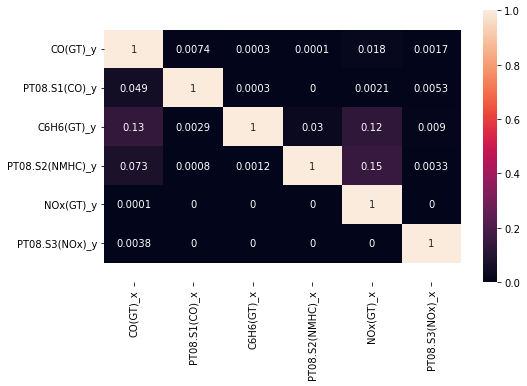

In [14]:
grangers_df = grangers_causation_matrix(data, variables = data.columns[:-1]) 

plt.figure(figsize=(8,5))
sns.heatmap(grangers_df, annot=True)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.show() 

### همانطور که در جدول بالا دیده میشود بعضی از سری ها برای اینکه توسط سری های دیگر پیشبینی شود دارای P-value بالای 5 درصد است پس توسط نمیتوان توسط گذشته سری های دیگر آنها را پیشبینی کرد پس این دو سری هم از داده ها حذف میکنیم. 

In [15]:
to_drop.remove('C6H6(GT)')
to_drop.remove('PT08.S2(NMHC)')

data=data[to_drop+['Date']]
data.head()

,CO(GT),PT08.S1(CO),NOx(GT),PT08.S3(NOx),Date
0,1.966667,1316.500000,132.000000,1167.250000,2004-03-10
1,2.175000,1244.062500,139.250000,1277.187500,2004-03-11
2,2.725000,1281.562500,167.916667,1101.718750,2004-03-12
3,2.625000,1330.555556,181.291667,993.159722,2004-03-13
4,2.416667,1360.927083,143.416667,1001.104167,2004-03-14


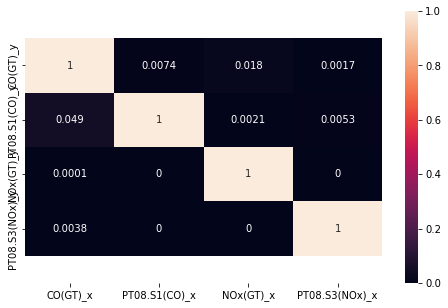

In [16]:
grangers_df = grangers_causation_matrix(data, variables = data.columns[:-1]) 

plt.figure(figsize=(8,5))
sns.heatmap(grangers_df, annot=True)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.show() 

### با نگاهی به P-Values ها در جدول بالا، تقریباً می توانید مشاهده کنید که اکثر متغیرها (سری های زمانی) در سیستم به طور مترادف یکدیگر را ایجاد می کنند. این باعث می شود این سیستم سری های زمانی چند کاندیدای مناسبی برای استفاده از مدل های VARMAX برای پیش بینی باشد.

# آزمون هم انباشتگی (Cointegration)
### آزمون هم انباشتگی به ایجاد ارتباط آماری معنی دار بین دو یا چند سری زمانی کمک می کند. هم انباشتگی یک ویژگی آماری از دو یا چند متغیر سری زمانی است که نشان می دهد آیا ترکیب خطی متغیرها ثابت است یا خیر.

### هنگامی که دو یا چند سری زمانی با هم ادغام می شوند، به این معنی است که آنها یک رابطه طولانی مدت و از نظر آماری معنی دار دارند.

### این فرض اولیه ای است که VARMAX بر آن استوار است. بنابراین معمول است که قبل از شروع به ساخت مدل های VARMAX، تست هم انباشتگی را اجرا کنیم.
### در اینجا فرض صفر وجود هم انباشتگی است.
### پیاده سازی آزمون هم انباشتگی در مدل های آماری پایتون را می توانید در زیر مشاهده کنید:

In [17]:
def find_cointegrated_pairs(dataframe, critial_level = 0.05):
    n = dataframe.shape[1] 
    pvalue_matrix = np.ones((n, n)) 
    keys = dataframe.columns 
    pairs = [] 
    for i in range(n):
        for j in range(i+1, n): 
            series1 = dataframe[keys[i]] 
            series2 = dataframe[keys[j]]
            result = sm.tsa.stattools.coint(series1, series2) 
            pvalue = result[1] 
            pvalue_matrix[i, j] = pvalue
            if pvalue < critial_level: 
                pairs.append((keys[i], keys[j], pvalue)) 
    return pvalue_matrix, pairs

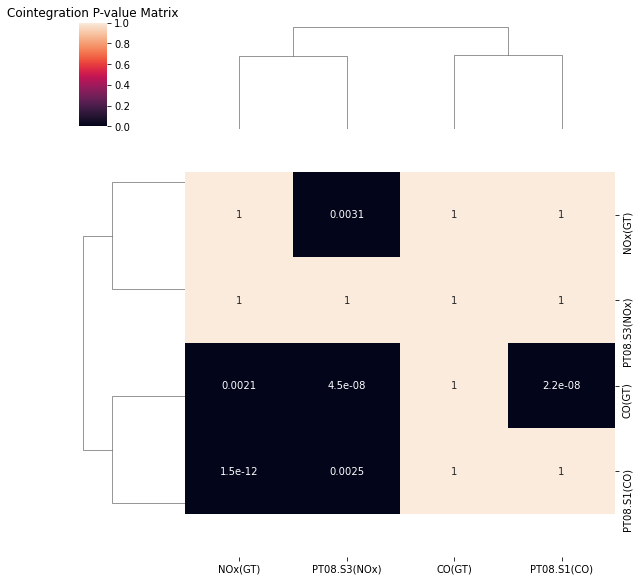

In [18]:
pvalue_matrix, pairs = find_cointegrated_pairs(data[data.columns[:-1]])
coint_pvalue_matrix_df = pd.DataFrame(pvalue_matrix)

g = sns.clustermap(coint_pvalue_matrix_df, xticklabels=data.columns,yticklabels=data.columns, annot=True, 
                   figsize=(8, 8))
plt.title('Cointegration P-value Matrix')
ax = g.ax_heatmap
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [19]:
pairs

[('CO(GT)', 'PT08.S1(CO)', 2.2105693234576845e-08),
 ('CO(GT)', 'NOx(GT)', 0.002059026139241235),
 ('CO(GT)', 'PT08.S3(NOx)', 4.500488230871522e-08),
 ('PT08.S1(CO)', 'NOx(GT)', 1.5125499513734411e-12),
 ('PT08.S1(CO)', 'PT08.S3(NOx)', 0.0025022643965020644),
 ('NOx(GT)', 'PT08.S3(NOx)', 0.003051936776807392)]

### با توجه با جدول بالا میتوان این فرض که ترکیب همه متغییر ها با هم همگرا است تایید میشود

# بررسی و آزمون برای ایستایی
### از آنجایی که مدل VARMAX مستلزم ایستا بودن سری زمانی است که میخواهید پیشبینی کنید، مرسوم است که تمام سری های زمانی سیستم را از نظر استا بودن بررسی کنید.

### سری زمانی ایستا سری زمانی است که میانگین و واریانس آن در طول زمان تغییر نمی کند.

### بنابراین، چگونه ثابت بودن را آزمایش کنیم؟  مجموعه ای از تست ها به نام تست های ریشه واحد وجود دارد. محبوب ترین آنها آزمون تست دیکی-فولر تقویت شده (Augmented Dickey-Fuller Test (ADF)) است و ما از همین آزمون برای برسی ایستایی استفاده میکنیم.
### پایین نمودار های هر سری زمانی نسبت به زمان و نمودار QQ-plot هر یک و همچنین نمودار های ACF و PACF برای 100 تاخیر اول برای تمام سری ها را رسم شده . در نمودار سری زمانی نسبت به زمان در نوشته کوچک گوشه نمودار مقدار P-Value بدست آمده از آزمون ADF نوشته شده و با نگاهی به این  P-Vlaue ها متوجه میشویم برخی از سری ها ایستا نیستند که از نمودار خود هبستگی و خود همبستگی جزيی آنها نیز میتوان متوجه این مسئله شد.

In [20]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \n'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

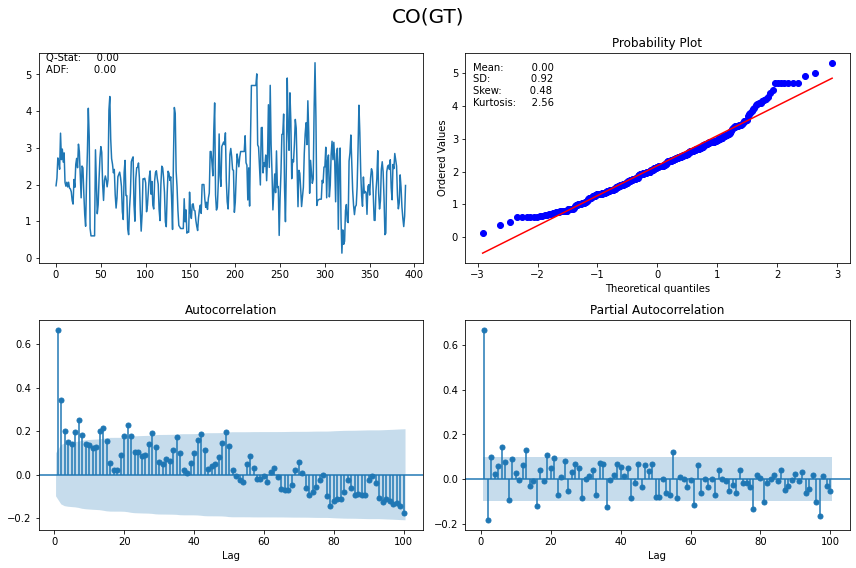

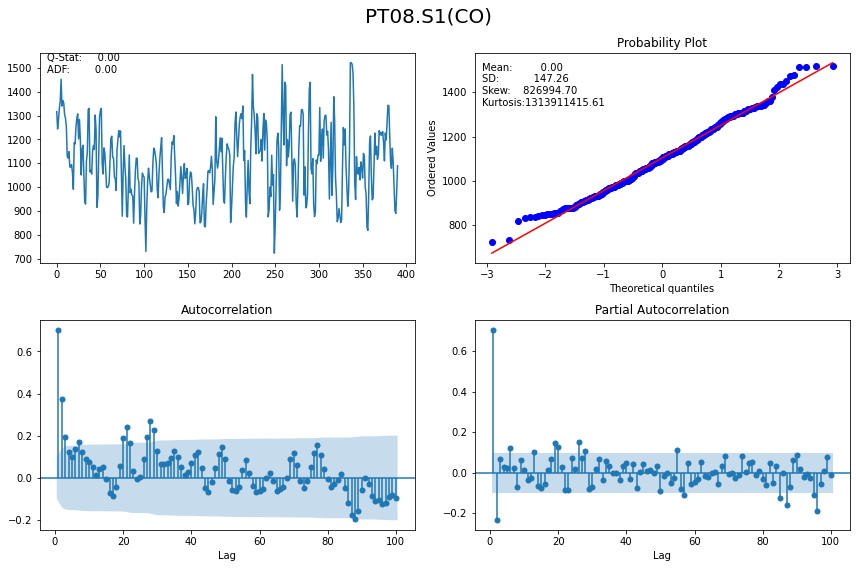

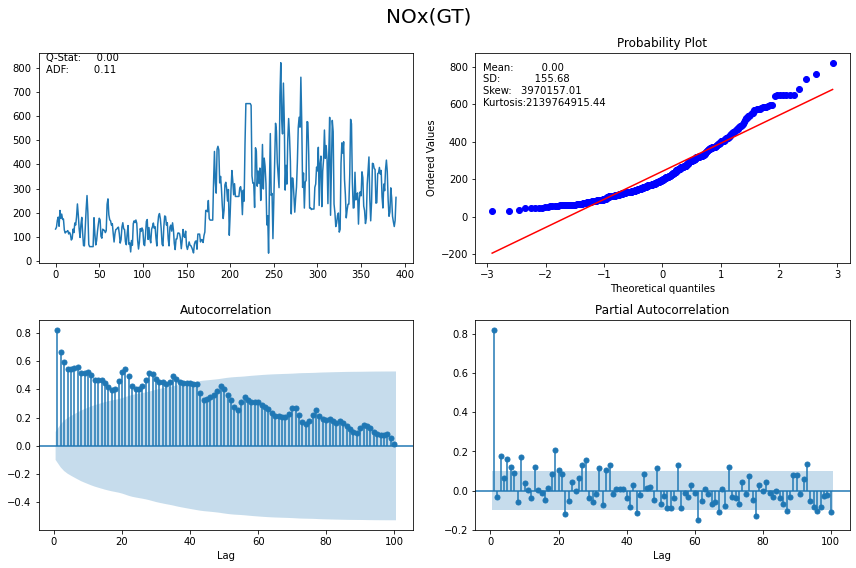

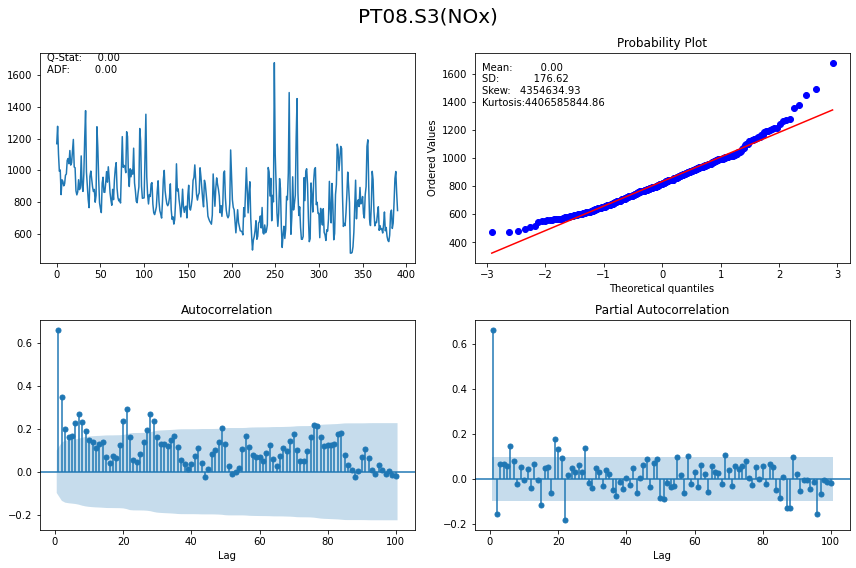

In [21]:
for i in data.columns[:-1]:
    plot_correlogram(data[i], lags=100, title=f'{i}')

In [22]:
def test_unit_root(df):
    return df.apply(lambda x: f'{pd.Series(adfuller(x)).iloc[1]:.2%}').to_frame('p-value')
test_unit_root(data[data.columns[:-1]])

,p-value
CO(GT),0.04%
PT08.S1(CO),0.00%
NOx(GT),10.75%
PT08.S3(NOx),0.01%


### همانطور که در بالا گفتیم و در جدول بالا که مقدار P-Value های بدست آمده از آزمون ریشه واحد است نیز میتوان دید بعضی از سری ها نا ایستا هستند.  میدانیم بزای ایستایی مدل یک روش موثر تفاضل گیری است به این صورت که از یک مشاهده مشاهده قبلش را کم میکنیم با دستور زیر عمل تفاضل گیری را یک مرتبه انجام داده و دوباره نمودار های در قسمت بالا را رسم میکنیم و میتوان هم از روی نمودار ها و هم از مقادیر P-Value میتوان دید سری ها ایستا شده اند.

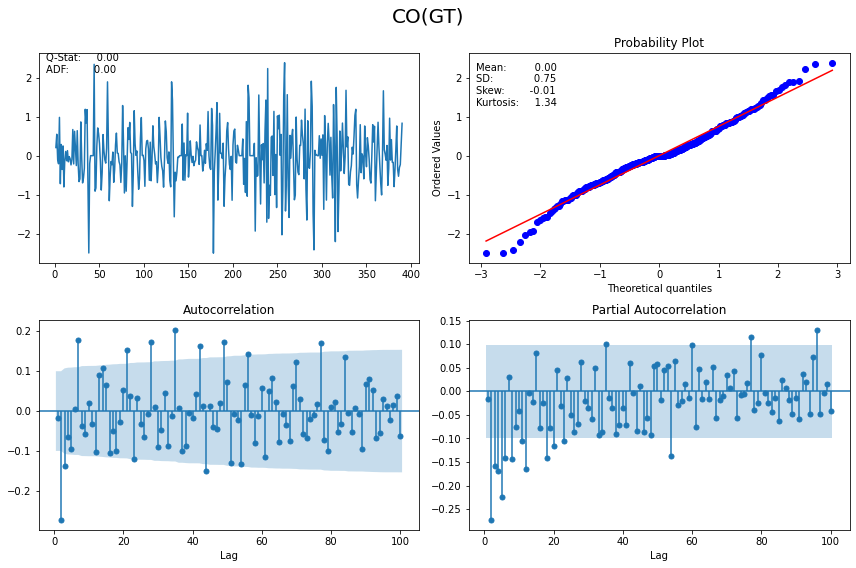

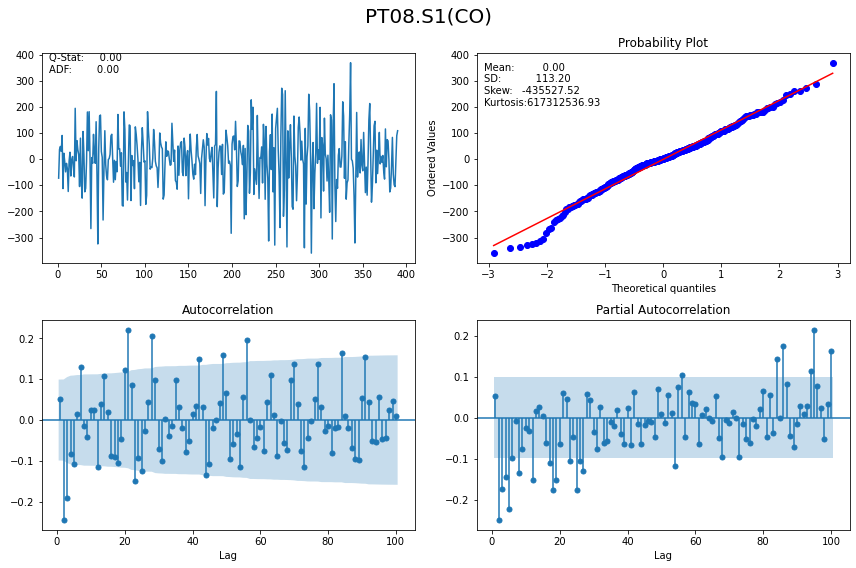

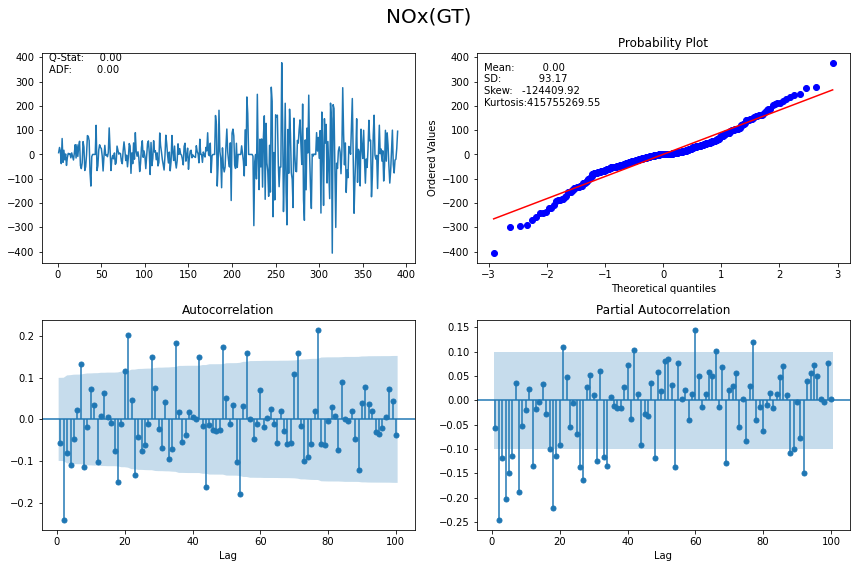

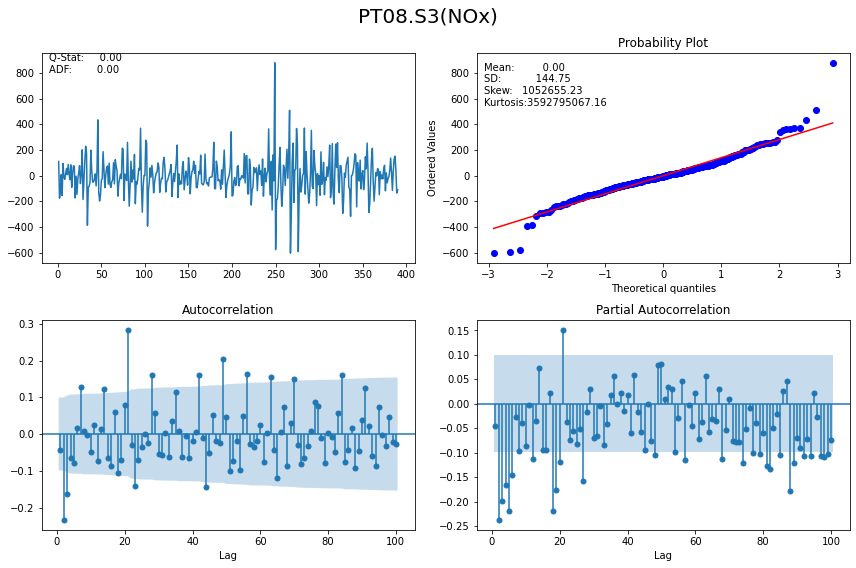

In [23]:
df_transformed = data[data.columns[:-1]].diff().dropna()
for col in data.columns[:-1]:
    df_transformed[col]=data[col].diff()

for i in df_transformed.columns:
    plot_correlogram(df_transformed[i], lags=100, title=f'{i}')

In [24]:
test_unit_root(df_transformed)

,p-value
CO(GT),0.00%
PT08.S1(CO),0.00%
NOx(GT),0.00%
PT08.S3(NOx),0.00%


# برازش مدل (Modeling) 


### در جدول و نمودار های بالا دیددیم که داده ها با یک مرتبه تفاضل گیری ایستا شدن حالا که داده های ایستا را داریم میتوانیم برای آنها مدل مناسب VARIMAX را برازش دهیم که میدانیم مرتبه تفاضل گیری آن یک است و باید به دنبال بهترین p و q که تعداد پارامتر های اتو رگرسیو و میانگین متحرکه مدل است بگردیم. 
### مدل VARIMAX در واقع خلاصه شده ( Vector Auto Regressive Integrated Moving Average with Exogeneous Input) است.دلیل استفاده از مدل VARIMAX هم این است که اولا در ورودی چند متغییر(سری زمانی) داریم و همچنین در خروجی هم میخواهیم آینده چند سری را پیشبینی کنیم یعنی مقادیر آینده هر سری از گذشته خود سری و بقیه سری ها پیشبینی میشود و همچنین یک مرتبه هم که تفاضل گیری داشتیم.  
### باید توجه داشت که متغییر های مورد استفاده در این مدل باید شراط خاصی را داشته باشند که در قسمت های قبل با انجام آزمون فرض های مناسب متغییر های مناسب استخراج شد.
 
 
 ### ابتدا با تابع auto arima که در کتابخانه های پایتون موجود است بهترین تعداد پارامترها (p,q) برای برازش مدل ARIMA برای تک تک سری ها به صورت تنها پیدا میکنیم. روند پیدا کردن این تابع هم به این صورت است که همه حالات موجود را با روش stepwise و تا ماکزیمم p,q برابر 7 و d برابر 1 که خودمان به برنامه دادیم و میشود تغییرش داد را بررسی میکند و مدلی که کمترین AIC را داشته باشد انتخاب میکند.
 ### دستور را انجام داده و بهترین p,q های بدست آمده با d برابر 1 را در خروجی مشاهده میکنیم.
 

In [25]:
pq = []
dtf=data[data.columns[:-1]]
for name, column in dtf[:351].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(dtf[name],d=1,start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : CO(GT)
optimal order for:CO(GT) is: (2, 1, 1) 


Searching order of p and q for : PT08.S1(CO)
optimal order for:PT08.S1(CO) is: (0, 1, 0) 


Searching order of p and q for : NOx(GT)
optimal order for:NOx(GT) is: (3, 1, 2) 


Searching order of p and q for : PT08.S3(NOx)
optimal order for:PT08.S3(NOx) is: (0, 1, 0) 




In [26]:
pq

[(2, 1, 1), (0, 1, 0), (3, 1, 2), (0, 1, 0)]

### در بالا p d q های بدست آمده از روش stepwise را مشاهده میکنیم که دو تا از آنها دارای p,q های برابر صفر است که نمیتوانیم p,q صفر را برای مدل در نظر گرفت چون آنگاه اصلا مدلی نداریم که بخواهد پیشبینی کند پس بین دوتای باقی مانده باید بهترین را انتخاب کنیم. 
### حال با استفاده از یکی از این p, q های باقی مانده p,q مناسب را برای مدل VARIMAX پیدا میکنیم. روند کار هم به این صورت است که ابتدا داده را به سه قسمت Train که شامل 350 داده اول قسمت validation شامل  35 داده بعدی و قسمت Test که شامل5 داده آخر است تقسیم میکنیم سپس با Cross validation که ینی با داده train مدل را برازش بدهیم و با داده های Validation خروجی ها را پیشبینی و با مقدار واقعی مقایسه کنیم و مدلی که کمترین MSE را داشت به عنوان مدل نهایی انتخاب کنیم دلیل این کار هم این است که مدلی خوب است که علاوه بر اینکه داده های موجود را خوب پیشبینی میکند باید بتواند در پیشبینی داده های جدید که در ساخت مدل هیچ مشارکتی نداشته اند نیز خوب عمل کند. و در آخر هم از داده های تست برای تست مدل استفاده میکنیم. 

In [27]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE CO(GT)','RMSE PT08.S1(CO)','RMSE NOx(GT)','RMSE PT08.S3(NOx)'])

for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        model = VARMAX(data[data.columns[:-1]][:351], order=(i[0],1,i[2])).fit( disp=False)
        result = model.forecast(steps = 35)
        
        COGT = np.sqrt(mean_squared_error(data[-40:-5]['CO(GT)'], result['CO(GT)']))
        PT08S1CO = np.sqrt(mean_squared_error(data[-40:-5]['PT08.S1(CO)'], result['PT08.S1(CO)']))
        NOxGT = np.sqrt(mean_squared_error(data[-40:-5]['NOx(GT)'], result['NOx(GT)']))
        PT08S3NOx = np.sqrt(mean_squared_error(data[-40:-5]['PT08.S3(NOx)'], result['PT08.S3(NOx)']))
        
        df_results_moni = df_results_moni.append({'p': i[0], 'q': i[2], 'RMSE CO(GT)':COGT,'RMSE PT08.S1(CO)':PT08S1CO,
                                                                             'RMSE NOx(GT)':NOxGT, 'RMSE PT08.S3(NOx)':PT08S3NOx }
                                                                              , ignore_index=True)
df_results_moni.sort_values(by = ['RMSE CO(GT)','RMSE PT08.S1(CO)','RMSE NOx(GT)','RMSE PT08.S3(NOx)'] ,ascending=False)

,p,q,RMSE CO(GT),RMSE PT08.S1(CO),RMSE NOx(GT),RMSE PT08.S3(NOx)
1,3.0,2.0,0.658932,123.990495,93.521314,190.347924
0,2.0,1.0,0.656632,124.934150,98.120498,190.367963


### همانطو که میبینیم حالت p=3 , q=2 دارای کمترین MSE برای همه سری ها است پس مدل نهایی ما یک مدل VARIMAX با p=3 ,q=2 , d=1 است. باید به این نکته اشاره داشت که نمیتوانست برای این داده ها مدل فصلی برازش داد چون داده ها در یک سال جمع آوری شده و ما برای برازش مدل فصلی به داده های چند سال نیاز دازیم.

### در پایین به همین صورت مقادیر داده های تست پیشبینی شده و نمودار آن در مقابل مقدار واقعی تست برای هر سری رسم شده است.


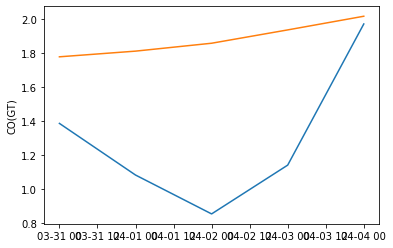

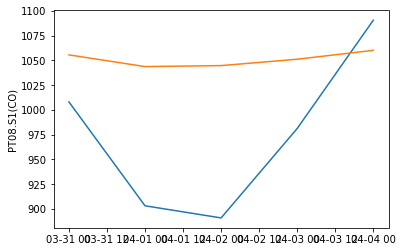

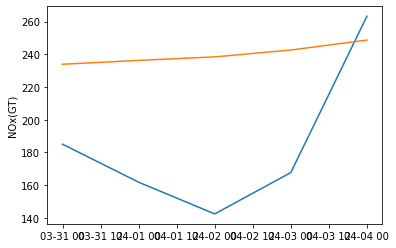

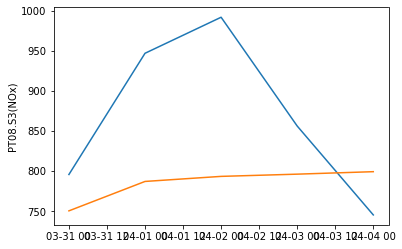

In [28]:
model = VARMAX(data[data.columns[:-1]][:386],order=(3,1,2)).fit( disp=False)
result = model.forecast(steps = 5)
for col in df_transformed.columns:
        
        plt.plot(data["Date"][-5:],data[col][-5:])
        
        plt.plot(data["Date"][-5:], result[col])
        plt.ylabel(str(col))

        plt.show()

# <font color='blue'>  برازش مدل LSTM  </font> 
 

### دیدیم که برای برازش مدل های کلاسیک اولا نتوانستیم از داده های ساعتی استفاده کنیم و دوم اینکه شرط ایستایی برای برازش مدل لازم بود و همچنین مدل از دقت چندان بالایی برخوردار نبود. پس نیازمند مدل هایی هستیم که این مشکلات را نداشته باشند .
## خلاصه ای از شبکه عصبی پرسپترون و LSTM
### شبکه عصبی پرسپترون چند لایه، یکی از ساده ترین مدل های شبکه عصبی مصنوعی است. در این مدل، ابتدا ورودی ها وارد مدل مدل می شوند. در مرحله بعد، با در اختیار داشتن مجموعه ای از وزن های متناظر با نودهای شبکه های عصبی، ورودی ها از لایه ورودی به سمت لایه های نهان و پس از آن به سمت لایه خروجی انتشار داده می شوند (انتشار رو به جلوی نمونه های ورودی).

### یادگیری شبکه عصبی پرسپترون چند لایه از طریق یک فرایند یادگیری به نام «پس انتشار خطا» (Error Backpropagation) انجام میشود. در این فرایند، خطای پیشبینی انجام شده در لایه خروجی شبکه، به سمت لایه های نهان پس انتشار داده میشود (انتشار رو به عقب خطای شبکه) و از این طریق، وزن های نودهای شبکه های عصبی تغییر میکنند.
 

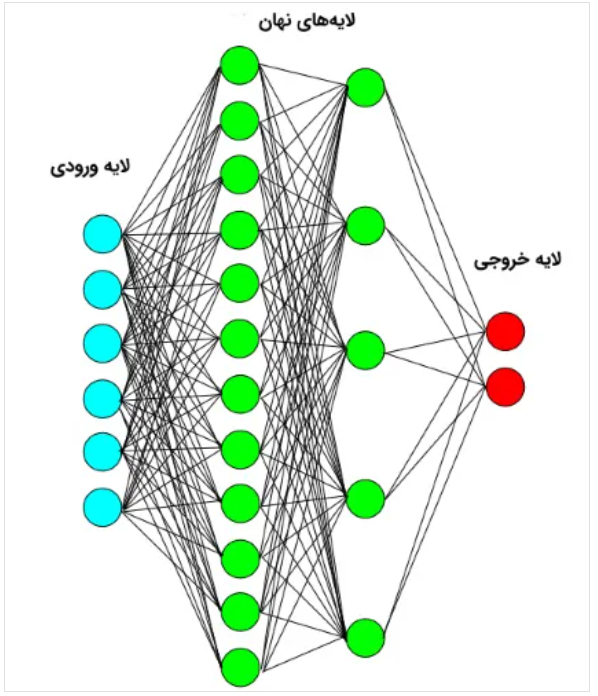

### مشکل مهم شبکه عصبی پرسپترون چند لایه، نبود حافظه است. به عبارت دیگر، شبکه هیچ اطلاعی در مورد نمونه های آموزشی که در تکرارهای گذشته وارد شبکه عصبی شده اند ندارد و نمی تواند تأثیر آموزش های گذشته را بر نمونه های آموزشی جدید بسنجد. در زمینه مدل های یادگیری جهت پیش بینی سهام شرکت ها و قیمت آنها، تفاوت میان داده های مرتبط با ده روز خاص در یک مجموعه داده، با داده های مرتبط با همان ده روز در مجموعه داده دیگر، ممکن از اهمیت ویژه ای برخوردار باشد. با این حال، شبکه عصبی پرسپترون چند لایه قادر به تحلیل چنین روابطی در داده ها نخواهد بود.

### در چنین حالتی و برای رفع چنین مشکلی در شبکه عصبی پرسپترون چند لایه، از شبکه عصبی بازگشتی با حافظه کوتاه مدت بلند استفاده میشود(LSTM). شبکه عصبی بازگشتی، قابلیت ذخیره اطلاعات خاصی را در مورد داده های ورودی دارد و میتواند از این اطلاعات در مراحل بعدی یادگیری استفاده کند. چنین ویژگی مهمی در شبکه عصبی بازگشتی، قابلیت شبکه در تحلیل ساختار پیچیدۀ روابط میان داده های با بازه زمانی کم را به شدت افزایش میدهد.

### مهم ترین مشکل شبکه های عصبی بازگشتی، «محو شدگی گرادیان» (Vanishing Gradient) است. دلیل وقوع چنین پدیده ای این است که با بالا رفتن تعداد لایه ها در شبکه، «نرخ یادگیری» (Learning Rate) چندین بار ضرب خواهد شد (نرخ یادگیری، مقداری کوچکتر از 1 است) و این سبب میشود تا مقادیر گرادیان های محاسبه شده مدام کاهش پیدا کنند. در نتیجه، در تکرارهای رو به انتها، وزن های شبکه عصبی تغییر محسوسی نخواهد کرد. چنین مشکلی با اضافه شدن واحد حافظه کوتاه مدت بلند (LSTM) به شبکه عصبی بازگشتی مرتفع شده است. به همین دلیل، شبکه عصبی بازگشتی با حافظه کوتاه مدت بلند، عملکرد بهتری نسبت به شبکه های عصبی بازگشتی مرسوم از خود نشان میدهد. 

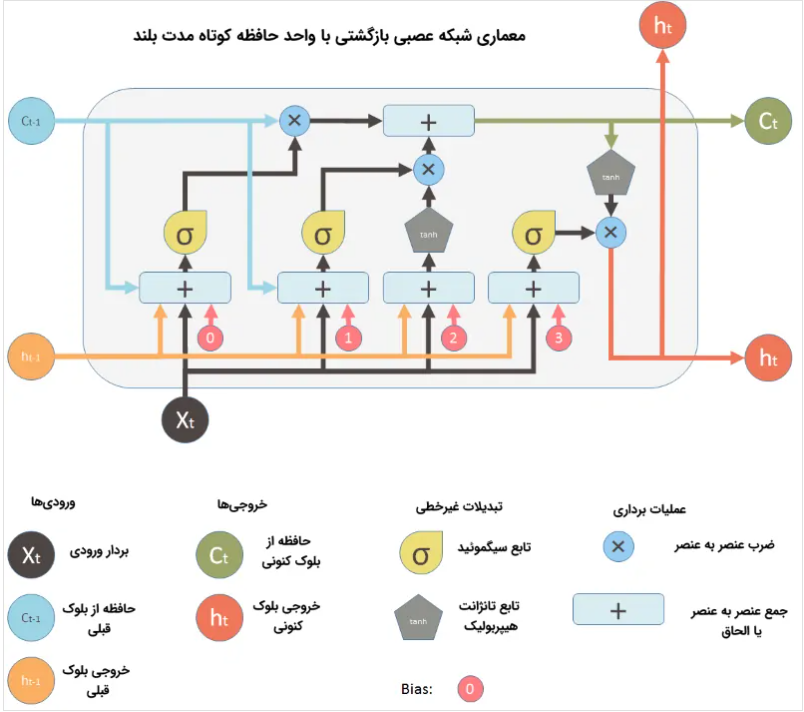

### برای پیاده سازی شبکه عصبی مصنوعی LSTM از کتابخانه keras پایتون استفاده میکنیم. ویژگی مهم در کتابخانه keras، اضافه کردن مرحله به مرحلۀ لایه ها، به جای تعریف ی باره مدل است. از این طریق، به راحتی میتوان تعداد لایه ها و نوع آن ها را تغییر داد؛ ویژگی ای که در هنگام بهینه سازی (Optimization) شبکه عصبی بسیار مفید خواهد بود. 

### فقط قبل از پیاده سازی ابتدا  به جای ستون زمان و تاریخ یک ستون که همزمان شامل زمان و تاریخ است به اسم (datetime) ایجاد میکنیم تا یک ستون مشخص برای index   زمان داشته باشیم سپس داده ها را به سه قسمت Train , Validation, Test تقسیم میکنیم. تا با همان روش cross validation بتوانیم در اینجا بهترین تعداد نود ها را بدست آورد که مقدار بهینه زمانی است که نمودار های زیان (loss) که در ادامه رسم میکنیم با بیشتر شدن نود ها تغییر چشمگیری نکند. 

In [29]:
datetime=[]
for i in hourly_data.index:
    datetime.append(str((hourly_data['Date'][i]).date())+str(hourly_data['Time'][i]))
hourly_data['datetime']=datetime
hourly_data.drop(['Time','Date'],axis=1 ,inplace=True)

hourly_data.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Day,month,year,datetime
0,2.6,1360.00,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754,10,3,2004,2004-03-1018:00:00
1,2.0,1292.25,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487,10,3,2004,2004-03-1019:00:00
2,2.2,1402.00,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239,10,3,2004,2004-03-1020:00:00
3,2.2,1375.50,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713,10,3,2004,2004-03-1021:00:00
4,1.6,1272.25,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794,10,3,2004,2004-03-1022:00:00


### تابع زیر برای تقسیم داده ها استفاده میشود

In [30]:
def split_sequences(features, targets, n_steps_in, n_steps_out, n_sliding_steps, window_type):
    """
    Edited from 
    https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
    
    Args:
    * features: univariate or multivariate input sequences
    * targets: univariate or multivariate output sequences
    * n_steps_in: length of input sequence for sliding window. 
    * n_steps_out: length of output sequence
    * n_sliding_steps: window step size
    * window_type: 'sliding' or 'expanding'
    """
    X, y = list(), list()
    for i in range(0, len(features), n_sliding_steps):

        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequences
        if out_end_ix > len(features):
            break
            
        # gather input and output parts of the pattern
        if window_type == 'sliding': # Sliding window
            seq_x, seq_y = features[i:end_ix, :], targets[end_ix:out_end_ix, :]
        else: # expanding window
            seq_x, seq_y = features[0:end_ix, :], targets[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

### و تابع زیر هم برای برازش مدل LSTM استفاده میشود

In [31]:
def Lstm_Model(data,input_cols,output_cols,N_EPOCHS)  :
    input_seq_length = 1
    output_seq_length = 1
    

    n_features = len(input_cols) - 1 # column timestep is not a feature

    X_all, y_all =split_sequences(data[input_cols].values, 
                       hourly_data[output_cols].values, 
                       n_steps_in = input_seq_length, 
                       n_steps_out = output_seq_length, 
                       n_sliding_steps = (output_seq_length), 
                       window_type='sliding')
    n_samples = X_all.shape[0]
    print(f"Total of {n_samples} samples created.")
    # Define model
    model = Sequential()
    model.add(LSTM(units=100,
               activation='relu', 
               input_shape=(input_seq_length, n_features))
         )
    model.add(Dense(units=output_seq_length))
    model.compile(optimizer='adam', loss='mse')
    
    # Data for training/validation
    X = X_all[:(n_samples - output_seq_length)]
    y = y_all[:(n_samples - output_seq_length)]

    # Data for testing
    X_test = X_all[(n_samples - 1):]
    y_test = y_all[(n_samples - 1):]
    # Split training and validation data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Covert to float and reshape
    index_X_train = X_train[:, :, 0]
    index_y_train = y_train[:, :, 0]
    index_X_val = X_val[:, :, 0]
    index_y_val = y_val[:, :, 0]
    index_X_test = X_test[:, :, 0]
    index_y_test = y_test[:, :, 0]

    X_train = X_train[:, :, 1:].astype(float).reshape((X_train.shape[0], 
                                                  input_seq_length, 
                                                  n_features))
    X_val = X_val[:, :, 1:].astype(float).reshape((X_val.shape[0], 
                                             input_seq_length, 
                                              n_features))
    X_test = X_test[:, :, 1:].astype(float).reshape((X_test.shape[0], 
                                                input_seq_length, 
                                                n_features))

    y_train = y_train[:, :, 1].astype(float)
    y_val = y_val[:, :, 1].astype(float)
    y_test = y_test[:, :, 1].astype(float)
    
    # Fit model
    history = model.fit(X_train, y_train, # Training data
                    validation_data=(X_val, y_val), # Validation data
                    epochs = N_EPOCHS, # Number of epochs
                    verbose = 0, # Don't show output. Set to 1 to see output
                    shuffle=False
                    )

    # Visalize loss over epochs
    plot_history(history)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
    val_pred=model.predict(X_val, verbose=0)
    y_pred = model.predict(X_test, verbose=0)
    #sns.lineplot(x=index_X_test[0], y=X_test[0].reshape(-1), ax=ax, color='mediumseagreen', label='in', marker='o')
    sns.lineplot(x=hourly_data[output_cols].values[:, 0], y=hourly_data[output_cols].values[:, 1].astype(float), ax=ax, color='grey', label='in', marker='o')
    sns.lineplot(x=index_y_test.reshape(-1), y=y_test.reshape(-1), ax=ax, color='coral', label='out', marker='o')
    sns.lineplot(x=index_y_test.reshape(-1), y=y_pred.reshape(-1), ax=ax, color='red', label='pred', marker='X', markersize=8)
    sns.lineplot(x=index_X_val.reshape(-1), y=val_pred.reshape(-1), ax=ax, color='blue', label='pred_val', marker='X')

    ax.set_title(f"Testing (MSE: {mean_squared_error(y_pred, y_test):.6f})")    

    plt.tight_layout()
    plt.show() 
    


### به کمک تابع های ایجاد شده مدل را برازش داده و نمودار تابع زیان (loss) در مقابل تعداد نود ها تا رسیدن به تعداد نود استفاده شده در مدل که برای این مدل ها این تعداد را 30 در نظر گرفته ایم رسم شده است. تعداد نود بهینه اونی است که با بالا رفتن تعداد نود اختلاف مقدار loss بین داده های validation , train دیگر تغییر چندادنی نکند و همچنین مقدار زیان در هر دو کمترین باشند.
### در پایین برای هر سری نمودار تابع زیان آن برای داده های validation, train در مقابل نود ها رسم شده و همچنین در نمودار های دوم برای هر سری خود دیتا های اصلی که با نقطه های با رنگ طوسی مقادیر پیشبینی شده توسط داده های validation با رنگ آبی و مقدار داده تست که یک مشاهده آخر برای آن در نظر گرفته شده و در پیدایش مدل هیج نقشی نداشته با رنگ نارجی و مقدار پیشبینی شده برای این داده توسط مدل با رنگ قرمز رسم شده تا بتوانیم دقت پیشبینی مدل را به وضوح ببینیم.
### در بالای هر یک از نمودار های دوم نیز مقدار mse برای داده تست (همان یک مشاهده آخر) نیز نوشته شده است. 

Result for :  CO(GT)
Total of 9356 samples created.


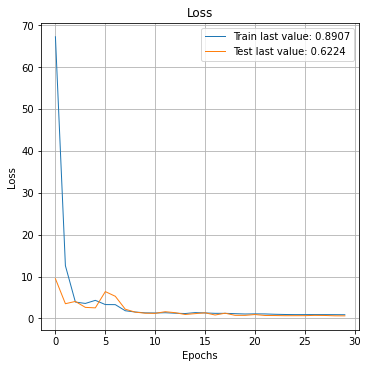

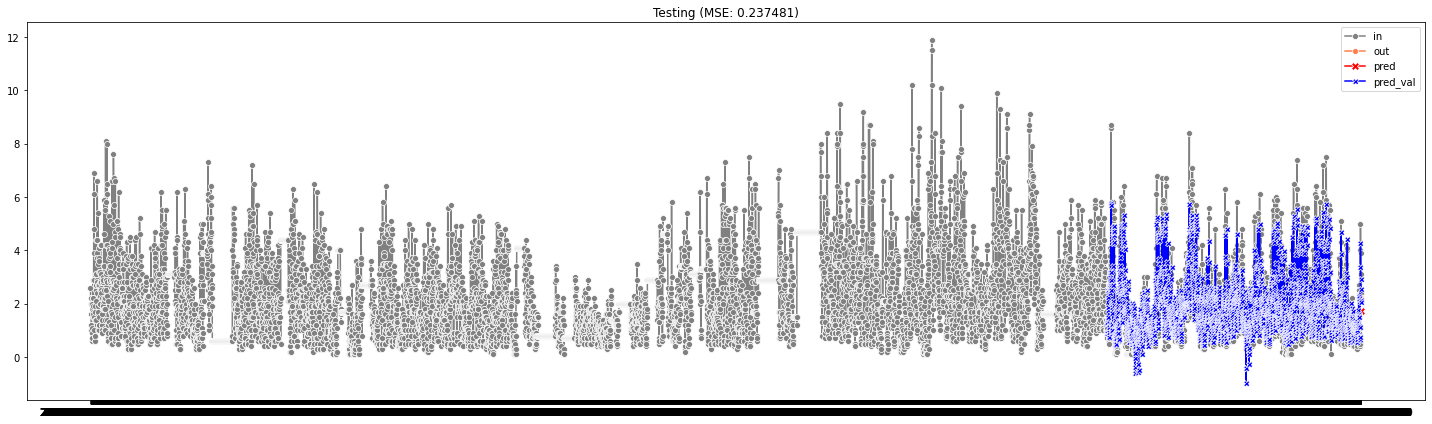

Result for :  PT08.S1(CO)
Total of 9356 samples created.


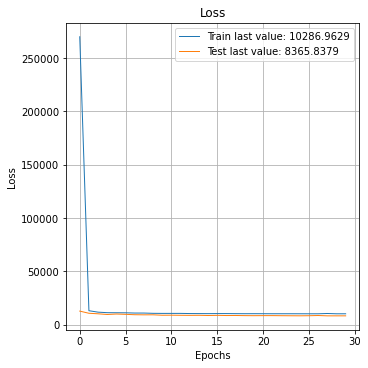

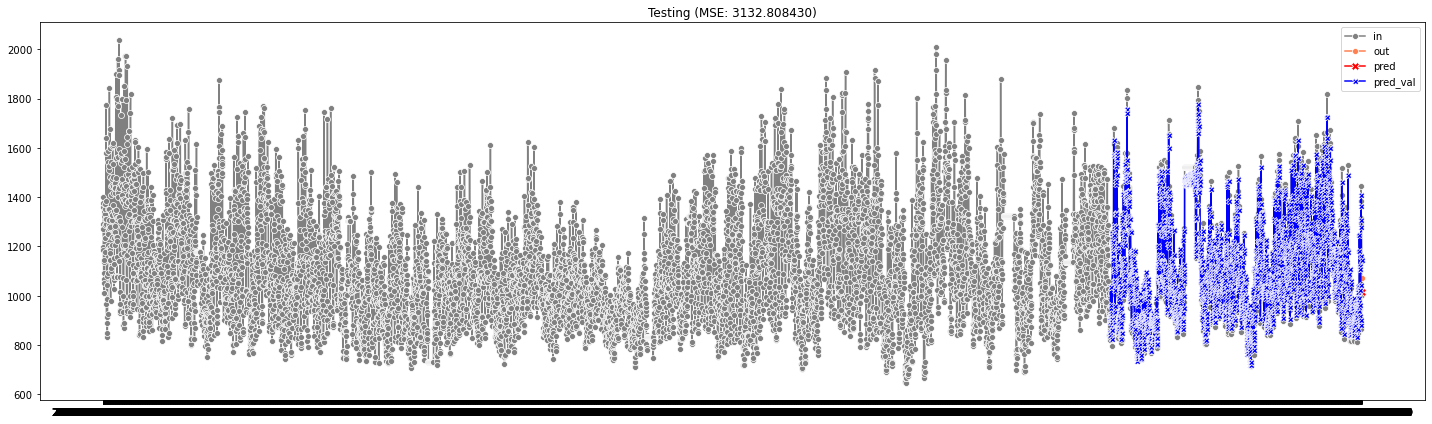

Result for :  NOx(GT)
Total of 9356 samples created.


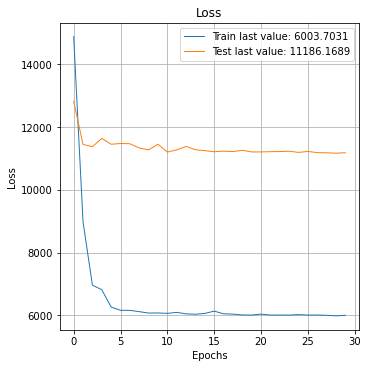

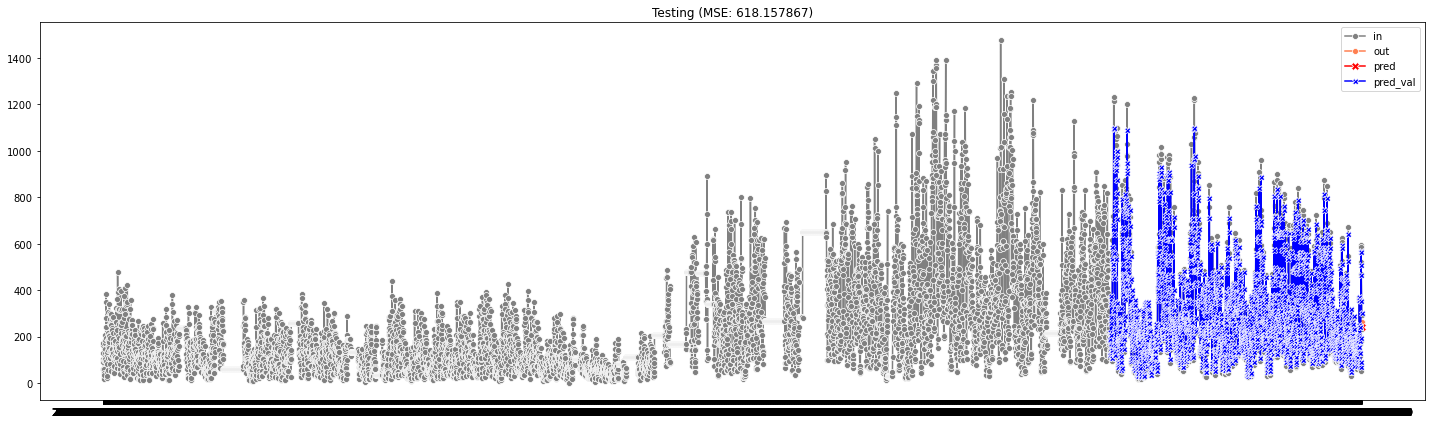

Result for :  PT08.S3(NOx)
Total of 9356 samples created.


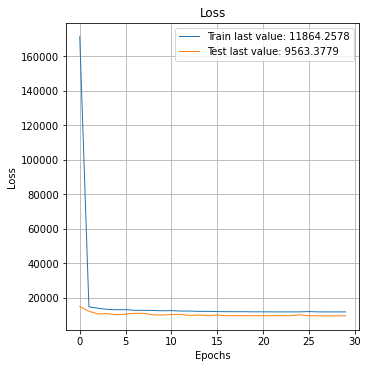

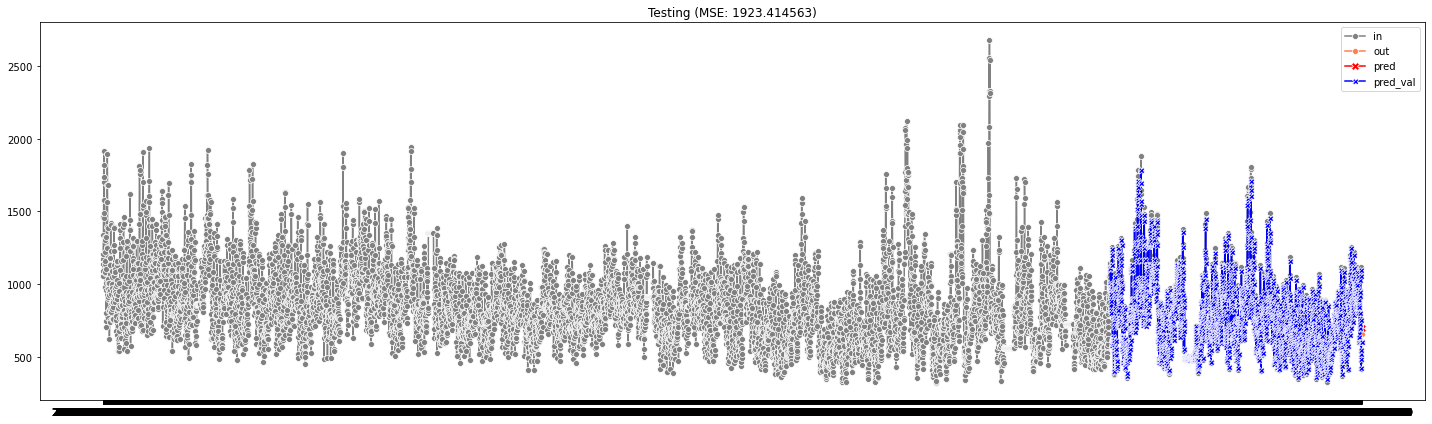

In [32]:
input_cols = ['datetime','CO(GT)','PT08.S1(CO)','NOx(GT)','PT08.S3(NOx)']
for feature in ['CO(GT)','PT08.S1(CO)','NOx(GT)','PT08.S3(NOx)'] :
        output_cols = ['datetime',feature]
        N_EPOCHS=30
        print('Result for :  '+feature)
        Lstm_Model(hourly_data,input_cols,output_cols,N_EPOCHS)  

# جمع بندی 
### در این پروژه سعی شد ابتدا ویژگی های مهم در رابطه با موضوع کیفیت هوا از داده ها استخراج کرده و آزمون فرض های مناسب جهت برازش مدل کلاسیک VARMAX را برای آنها انجام داده و مناسب ترین مدل را انتخاب کردیم.
### و در ادامه دیدیم که مدل های شبکه های عصبی با دقت عمل بسیار بالا و زمان و محاسبات کمتر توانستند مدل های مناسب تری برای ما باشند از روش های استفاده شده در این پروژه میتوان برای برازش داده های متفاوت دیگر که به زمان وابسته هستند نیز استفاده کرد و همچنین در بحث شبکه های عصبی مدل های گوناگونی وجود دارد که میتوان بر حسب نیاز برای داده های مناسب از آنها استفاده کرد


######  <font color='blue'>  با سپاس از همراهی شما  </font> 